In [3]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.gridspec import GridSpec

from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY
from mtj.types import MaterialProps

In [6]:
def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.008,  # Damping factor (arbitrarily chosen in this demo)
    K_u=0,  # Crystal anisotropy constant, default: 0
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.zeros(3, dtype=np.float64),  # Not used when K_0 = 0
    N=np.diag([0, 0, 1]),  # Default: "infinite" thin film
    T=0,  # Temperature (K) - H_th diabled if 0
    Vol=1e-9 * 25e-9**2 * np.pi,  # Volume
    Volt=0,  # STT voltage
    p=np.array([1, 0, 0]),  # STT polarizer orientation
    a_par=0,  # STT coefficients
    a_perp=0,
    stt_enable=False,
    recompute_H_th=False,
    recompute_H_eff=False,
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))
    params: MaterialProps = {
        "K_u": K_u,
        "M_s": M_s,
        "u_k": u_k,
        "p": p,
        "a_para": a_par,
        "a_ortho": a_perp,
        "V": Volt,
        "H_app": H_app,
        "N": N,
    }

    for i, t in enumerate(time_series[:-1]):
        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(
            m[i],
            T,
            Vol,
            dt,
            alpha,
            stt_enable=stt_enable,
            recompute_H_th=recompute_H_th,
            recompute_H_eff=recompute_H_eff,
            **params,
        )

    return m, time_series

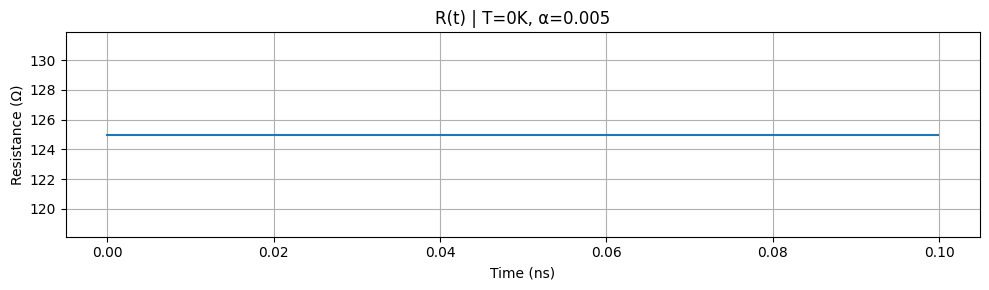

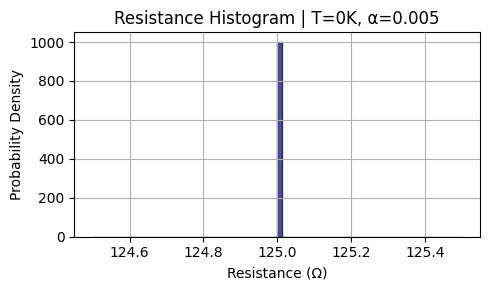

T=0K, α=0.005 → Mean R = 125.000 Ω, Std Dev = 0.00000 Ω


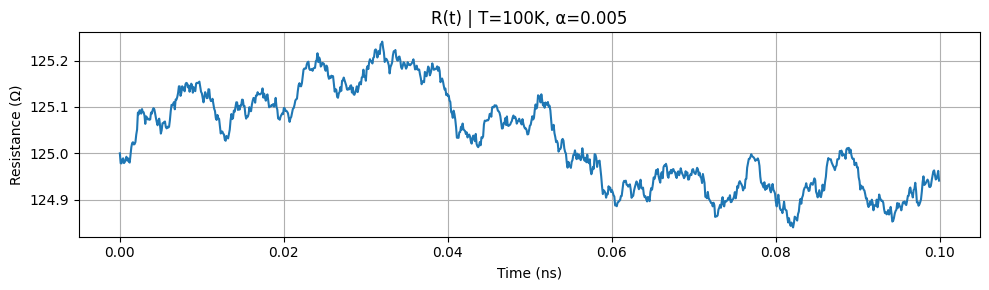

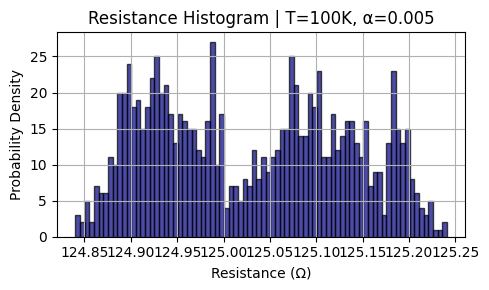

T=100K, α=0.005 → Mean R = 125.030 Ω, Std Dev = 0.10308 Ω


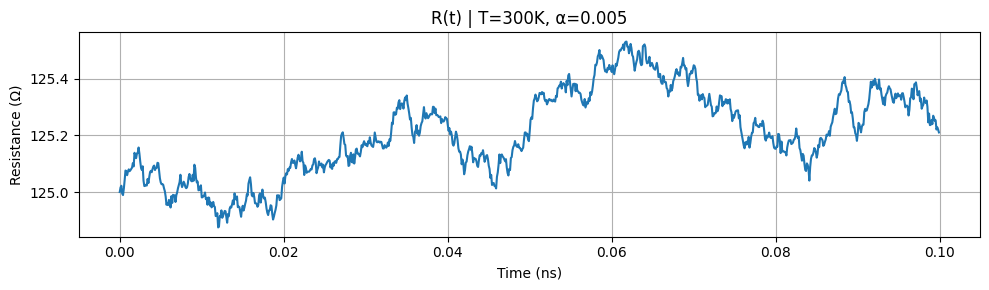

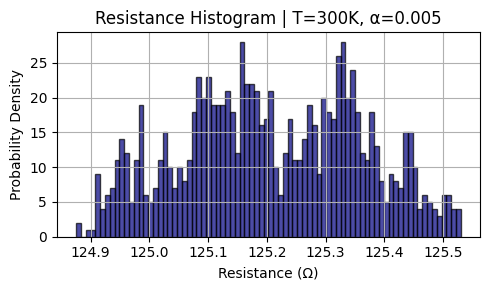

T=300K, α=0.005 → Mean R = 125.208 Ω, Std Dev = 0.15170 Ω


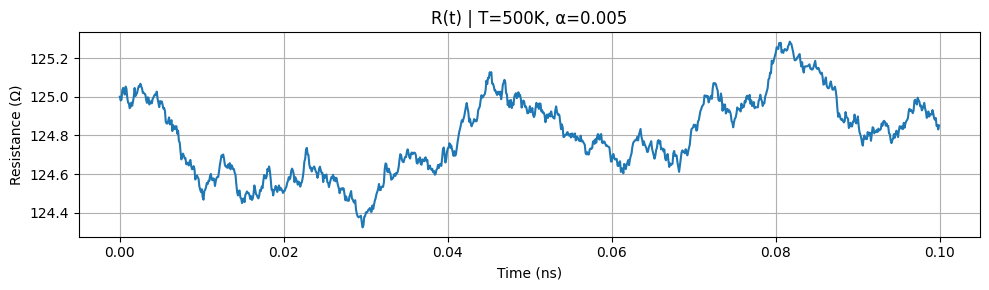

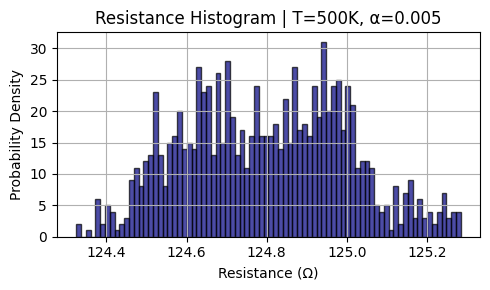

T=500K, α=0.005 → Mean R = 124.800 Ω, Std Dev = 0.20237 Ω


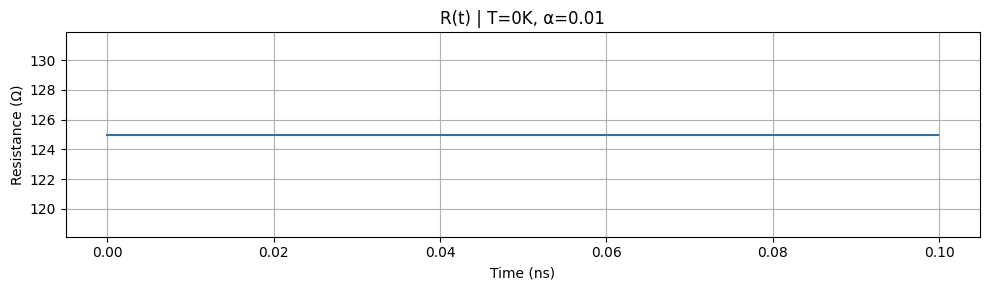

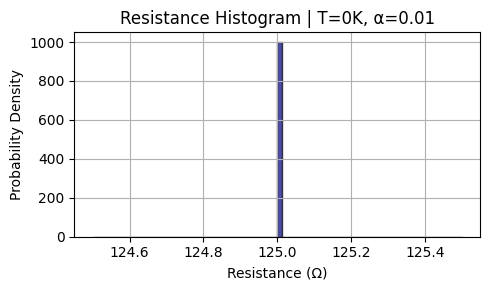

T=0K, α=0.01 → Mean R = 125.000 Ω, Std Dev = 0.00000 Ω


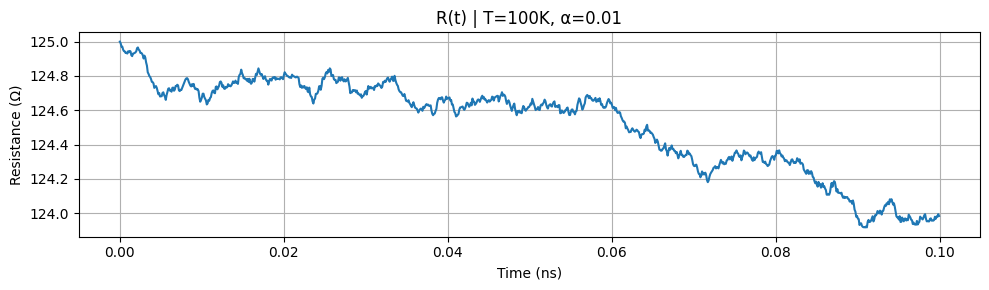

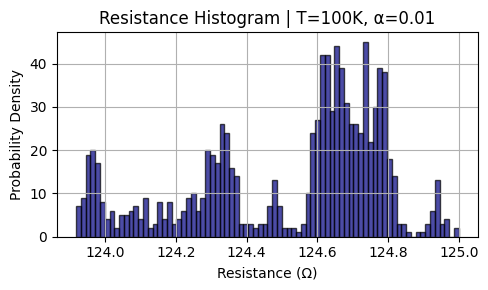

T=100K, α=0.01 → Mean R = 124.518 Ω, Std Dev = 0.27135 Ω


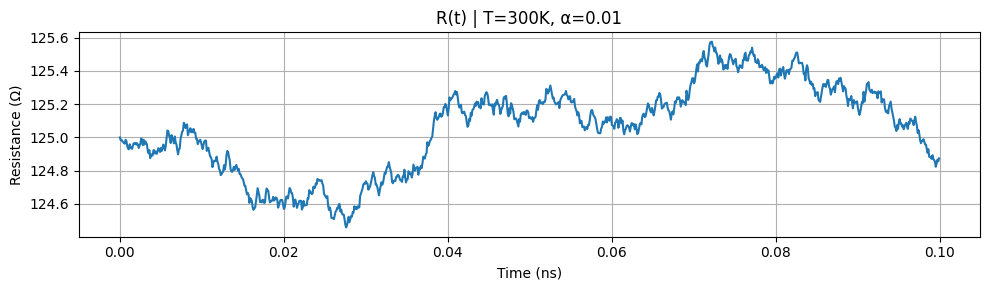

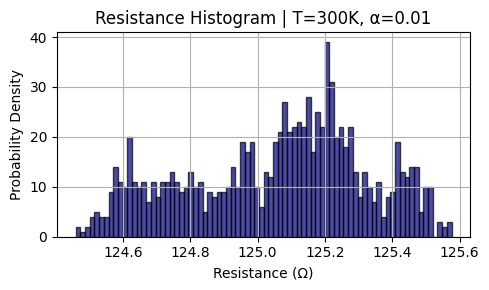

T=300K, α=0.01 → Mean R = 125.057 Ω, Std Dev = 0.26506 Ω


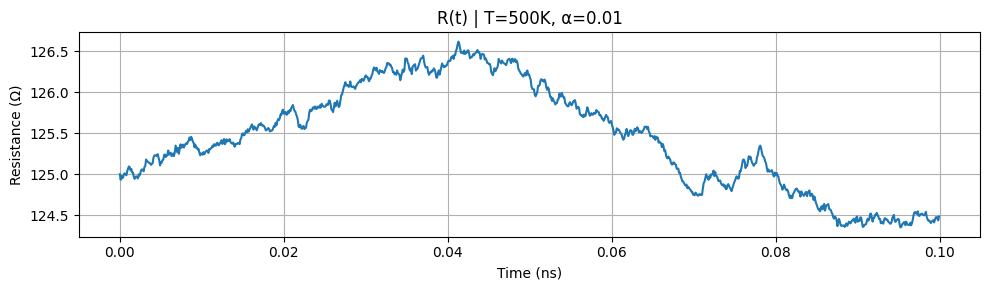

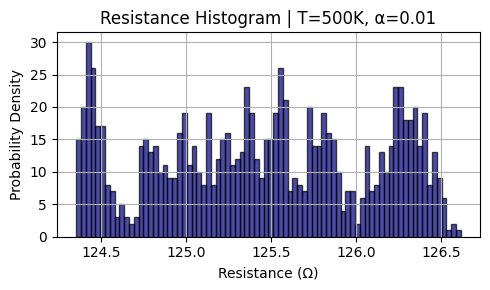

T=500K, α=0.01 → Mean R = 125.446 Ω, Std Dev = 0.63770 Ω


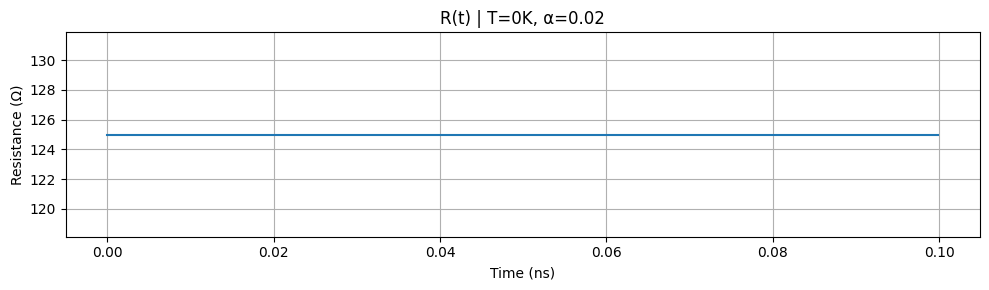

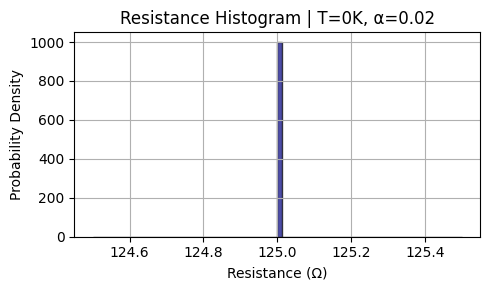

T=0K, α=0.02 → Mean R = 125.000 Ω, Std Dev = 0.00000 Ω


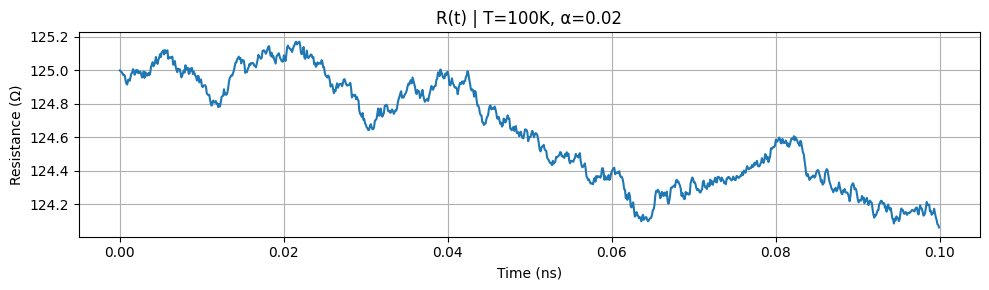

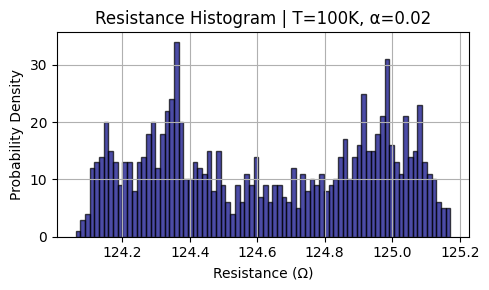

T=100K, α=0.02 → Mean R = 124.625 Ω, Std Dev = 0.32285 Ω


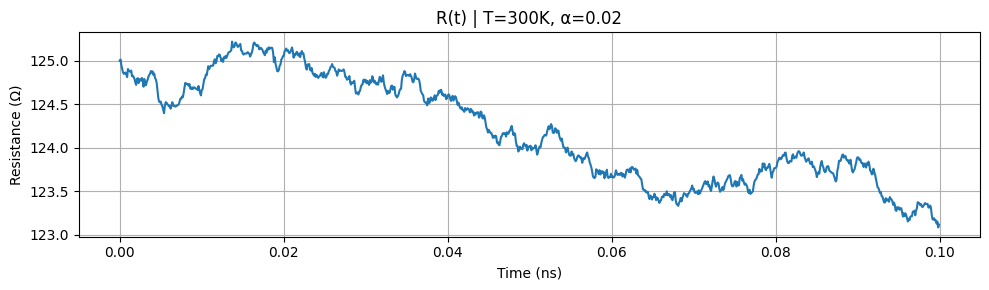

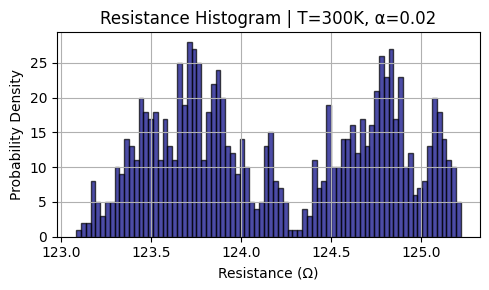

T=300K, α=0.02 → Mean R = 124.193 Ω, Std Dev = 0.59294 Ω


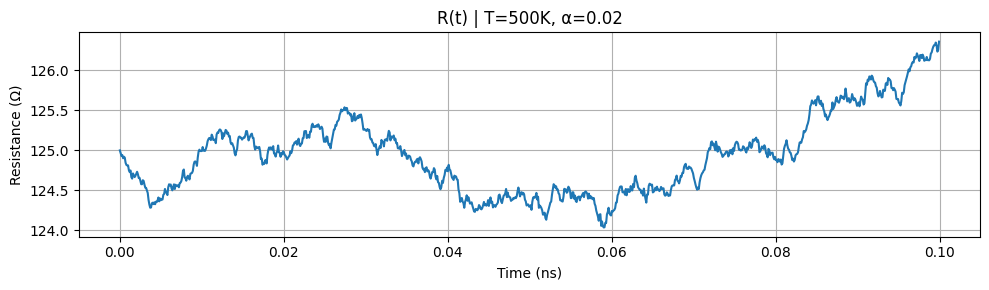

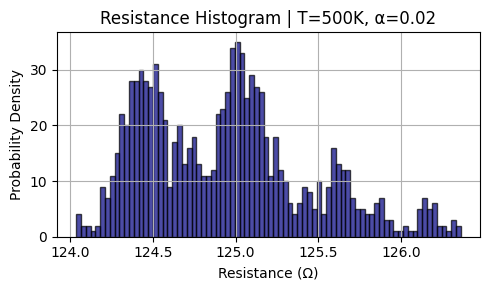

T=500K, α=0.02 → Mean R = 124.942 Ω, Std Dev = 0.49531 Ω


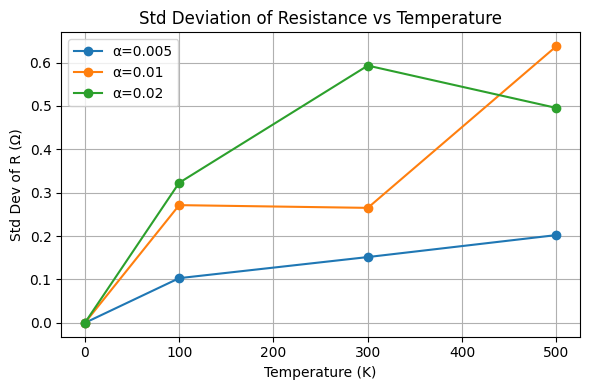

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

m0 = np.array([1, 0, 0])         # Initial magnetization direction
H_app = np.zeros(3)              # No applied field
dt = 1e-13                       # Time step (s)
Tn = 1e-10                       # Total simulation time
VACUUM_PERMEABILITY = 4 * np.pi * 1e-7  # μ₀ in H/m
Vol = 1e-9 * 25e-9**2 * np.pi    # Volume in m³

# Resistance model: TMR effect
def magnetization_to_resistance(m_z, R_P=100, delta_R=50):
    return R_P + (delta_R / 2) * (1 - m_z)

# Input ranges
alphas = [0.005, 0.01, 0.02]
temperatures = [0, 100, 300, 500]

# Store stats
std_devs_by_alpha = {alpha: [] for alpha in alphas}
means_by_alpha = {alpha: [] for alpha in alphas}

for alpha in alphas:
    for T in temperatures:
        m, ts = calculate_magnetization(
            m0=m0,
            H_app=H_app,
            Tn=Tn,
            dt=dt,
            alpha=alpha,
            M_s=1 / VACUUM_PERMEABILITY,
            Vol=Vol,
            T=T,
        )
        m_z = m[:, 2]
        R_series = magnetization_to_resistance(m_z)

        # --- Plot 1: Resistance vs Time ---
        plt.figure(figsize=(10, 3))
        plt.plot(ts * 1e9, R_series)
        plt.title(f"R(t) | T={T}K, α={alpha}")
        plt.xlabel("Time (ns)")
        plt.ylabel("Resistance (Ω)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Plot 2: Histogram of Resistance ---
        plt.figure(figsize=(5, 3))
        plt.hist(R_series, bins=80, alpha=0.7, color='navy', edgecolor='black')
        plt.title(f"Resistance Histogram | T={T}K, α={alpha}")
        plt.xlabel("Resistance (Ω)")
        plt.ylabel("Probability Density")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Store Statistics ---
        R_mean = np.mean(R_series)
        R_std = np.std(R_series)
        means_by_alpha[alpha].append(R_mean)
        std_devs_by_alpha[alpha].append(R_std)
        print(f"T={T}K, α={alpha} → Mean R = {R_mean:.3f} Ω, Std Dev = {R_std:.5f} Ω")

# --- Plot: Std Deviation vs Temperature for Each α ---
plt.figure(figsize=(6, 4))
for alpha in alphas:
    plt.plot(temperatures, std_devs_by_alpha[alpha], marker='o', label=f"α={alpha}")
plt.title("Std Deviation of Resistance vs Temperature")
plt.xlabel("Temperature (K)")
plt.ylabel("Std Dev of R (Ω)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

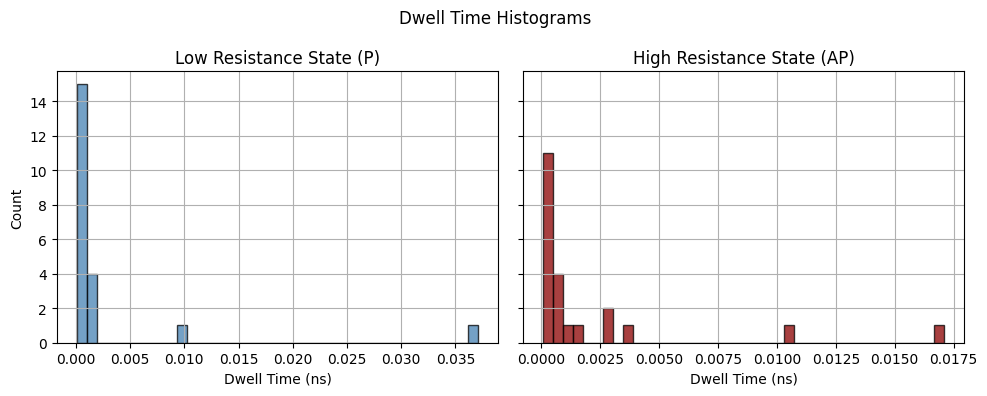

--- Events ---
  Low Resistance State (P):  21 events
  High Resistance State (AP): 22 events


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def extract_dwell_times(R_series, ts, threshold):
    states = (R_series >= threshold).astype(int)  # 0: low (P), 1: high (AP)
    dwell_times = []
    current_state = states[0]
    start_time = ts[0]

    for i in range(1, len(states)):
        if states[i] != current_state:
            dwell_duration = ts[i] - start_time
            dwell_times.append((current_state, dwell_duration))
            current_state = states[i]
            start_time = ts[i]

    # Append final dwell time
    dwell_times.append((current_state, ts[-1] - start_time))
    return dwell_times

def plot_dwell_histograms(dwell_times, dt_unit='ns'):
    dwell_0 = [dt for s, dt in dwell_times if s == 0]
    dwell_1 = [dt for s, dt in dwell_times if s == 1]

    if dt_unit == 'ns':
        dwell_0 = [x * 1e9 for x in dwell_0]
        dwell_1 = [x * 1e9 for x in dwell_1]
        unit_label = 'Dwell Time (ns)'
    else:
        unit_label = 'Dwell Time (s)'

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    axs[0].hist(dwell_0, bins=40, color='steelblue', edgecolor='black', alpha=0.75)
    axs[0].set_title("Low Resistance State (P)")
    axs[0].set_xlabel(unit_label)
    axs[0].set_ylabel("Count")
    axs[0].grid(True)

    axs[1].hist(dwell_1, bins=40, color='darkred', edgecolor='black', alpha=0.75)
    axs[1].set_title("High Resistance State (AP)")
    axs[1].set_xlabel(unit_label)
    axs[1].grid(True)

    plt.suptitle("Dwell Time Histograms")
    plt.tight_layout()
    plt.show()

    print(f"--- Events ---")
    print(f"  Low Resistance State (P):  {len(dwell_0)} events")
    print(f"  High Resistance State (AP): {len(dwell_1)} events")

# Convert the z-component of magnetization to MTJ resistance
m_z = m[:, 2]
R_series = magnetization_to_resistance(m_z)

# Extract dwell times and plot histograms
threshold = 125  # midpoint between RP = 100 and RAP = 150
dwell_times = extract_dwell_times(R_series, ts, threshold)
plot_dwell_histograms(dwell_times)

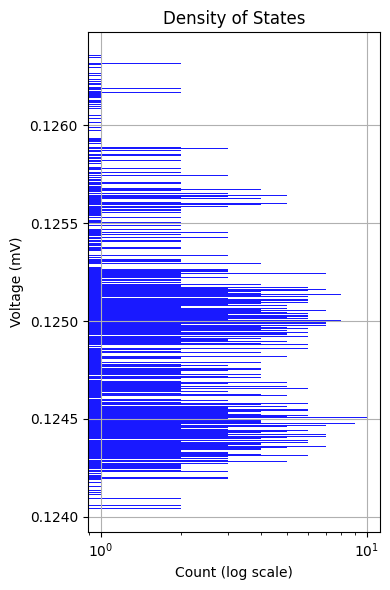

In [16]:
import numpy as np
import matplotlib.pyplot as plt

I = 1e-3  # example: 1 mA current
V_series = I * R_series  # R_series from your magnetization simulation

plt.figure(figsize=(4, 6))
plt.hist(V_series, bins=500, orientation='horizontal', color='blue', alpha=0.9)
plt.yscale('linear')  # voltage is linear
plt.xscale('log')     # log scale for counts
plt.xlabel("Count (log scale)")
plt.ylabel("Voltage (mV)")
plt.title("Density of States")
plt.grid(True)
plt.tight_layout()
plt.show()